# Geolocation of NYC Airbnb

Geospatial information is data that is referenced by spatial or geographic coordinates. The data that we will be working with in this project is vector data - features that are represented by points, lines, and polygons. <br>
 - **Points** are defined by a pair of (x,y) coordinates. They usually represent locations, place names, and other objects on the ground.
 - **Lines** are the connection between two points. They can have properties such as length, direction, flow, etc.
 - **Polygons** are a series of lines connected together to form a shape. They can have properties such as area, perimeters, and centroids. 
 
In this notebook, we will show the plots of airbnb hostings on NY map and see how it looks like, the geodata file we need is downloaded from the website given at the [NYCAirbnb](http://insideairbnb.com/get-the-data.html).

In [1]:
import pandas as pd
import geopandas as gpd #used for transforming geolocation data
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime  #to convert data to datetime that does not fall within the pandas.to_datetime function timeframe
from shapely.geometry import Point  #transform latitude/longitude to geo-coordinate data
from geopandas.tools import geocode #get the latitude/longitude for a given address
from geopandas.tools import reverse_geocode  #get the address for a location using latitude/longitude

%matplotlib inline

### NYC Airbnb sites


In [2]:
#load meteorite data collected from NASA Open Data API
NYC_df = pd.read_csv("datasets/df_text.csv")
NYC_df.head()

,Unnamed: 0,listing_id,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,comments,neighbourhood_group
0,0,2060,2259,Jenny,Washington Heights,40.85722,-73.93790,Private room,$100.00,1,1,2008-09-22,0.01,365,"very nice neighborhood,close enough to ""A"" tra...",Manhattan
1,1,3831,361855,Kurt,Washington Heights,40.83403,-73.93951,Entire home/apt,$265.00,3,35,2020-01-27,0.42,329,"Spacious, near public transportation, good pri...",Manhattan
2,2,3831,523218,Giorgio,Washington Heights,40.85295,-73.93361,Private room,$67.00,2,151,2020-02-18,1.39,298,A well located spot in a quieter neighbourhood...,Manhattan
3,3,5099,793620,Yvette,Washington Heights,40.84468,-73.94303,Private room,$75.00,2,40,2020-02-01,0.38,272,"Tinas Appartement war so wie beschrieben, es i...",Manhattan
4,4,5178,1423613,Arthur,Washington Heights,40.85774,-73.92901,Entire home/apt,$65.00,85,21,2020-03-03,0.36,230,My first experience using airbnb was great! Th...,Manhattan


In [3]:
#data type of each column
NYC_df.dtypes

Unnamed: 0               int64
listing_id               int64
host_id                  int64
host_name               object
neighbourhood           object
latitude               float64
longitude              float64
room_type               object
price                   object
minimum_nights           int64
number_of_reviews        int64
last_review             object
reviews_per_month      float64
availability_365         int64
comments                object
neighbourhood_group     object
dtype: object

In [4]:
#see columns with null values
NYC_df.count()

Unnamed: 0             22702
listing_id             22702
host_id                22702
host_name              22698
neighbourhood          22702
latitude               22702
longitude              22702
room_type              22702
price                  22702
minimum_nights         22702
number_of_reviews      22702
last_review            18011
reviews_per_month      18011
availability_365       22702
comments               22696
neighbourhood_group    22702
dtype: int64

In [5]:
#only include rows with non-null latitudes (which means longitude is also not null) and non-null mass
NYC_df = NYC_df.loc[(NYC_df['latitude'].notnull()) & NYC_df['room_type'].notnull()]
NYC_df.count()

Unnamed: 0             22702
listing_id             22702
host_id                22702
host_name              22698
neighbourhood          22702
latitude               22702
longitude              22702
room_type              22702
price                  22702
minimum_nights         22702
number_of_reviews      22702
last_review            18011
reviews_per_month      18011
availability_365       22702
comments               22696
neighbourhood_group    22702
dtype: int64

In [6]:
#make a new column to hold the longitude & latitude as a list
NYC_df['coordinates'] = list(NYC_df[['longitude', 'latitude']].values)

In [7]:
#see new coordinates column
NYC_df.head()

,Unnamed: 0,listing_id,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,comments,neighbourhood_group,coordinates
0,0,2060,2259,Jenny,Washington Heights,40.85722,-73.93790,Private room,$100.00,1,1,2008-09-22,0.01,365,"very nice neighborhood,close enough to ""A"" tra...",Manhattan,"[-73.9379, 40.85722]"
1,1,3831,361855,Kurt,Washington Heights,40.83403,-73.93951,Entire home/apt,$265.00,3,35,2020-01-27,0.42,329,"Spacious, near public transportation, good pri...",Manhattan,"[-73.93951, 40.83403]"
2,2,3831,523218,Giorgio,Washington Heights,40.85295,-73.93361,Private room,$67.00,2,151,2020-02-18,1.39,298,A well located spot in a quieter neighbourhood...,Manhattan,"[-73.93361, 40.85295]"
3,3,5099,793620,Yvette,Washington Heights,40.84468,-73.94303,Private room,$75.00,2,40,2020-02-01,0.38,272,"Tinas Appartement war so wie beschrieben, es i...",Manhattan,"[-73.94303000000002, 40.84468]"
4,4,5178,1423613,Arthur,Washington Heights,40.85774,-73.92901,Entire home/apt,$65.00,85,21,2020-03-03,0.36,230,My first experience using airbnb was great! Th...,Manhattan,"[-73.92900999999998, 40.85774]"


In [8]:
#list values in coordinates column is classified as object type
NYC_df['coordinates'].dtypes

dtype('O')

In [9]:
#convert the coordinates to a geolocation type
NYC_df['coordinates'] = NYC_df['coordinates'].apply(Point)

In [10]:
#coordinates column now has POINT next to each coordinate pair value
NYC_df.head()

,Unnamed: 0,listing_id,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,comments,neighbourhood_group,coordinates
0,0,2060,2259,Jenny,Washington Heights,40.85722,-73.93790,Private room,$100.00,1,1,2008-09-22,0.01,365,"very nice neighborhood,close enough to ""A"" tra...",Manhattan,POINT (-73.9379 40.85722)
1,1,3831,361855,Kurt,Washington Heights,40.83403,-73.93951,Entire home/apt,$265.00,3,35,2020-01-27,0.42,329,"Spacious, near public transportation, good pri...",Manhattan,POINT (-73.93951 40.83403)
2,2,3831,523218,Giorgio,Washington Heights,40.85295,-73.93361,Private room,$67.00,2,151,2020-02-18,1.39,298,A well located spot in a quieter neighbourhood...,Manhattan,POINT (-73.93361 40.85295)
3,3,5099,793620,Yvette,Washington Heights,40.84468,-73.94303,Private room,$75.00,2,40,2020-02-01,0.38,272,"Tinas Appartement war so wie beschrieben, es i...",Manhattan,POINT (-73.94303000000002 40.84468)
4,4,5178,1423613,Arthur,Washington Heights,40.85774,-73.92901,Entire home/apt,$65.00,85,21,2020-03-03,0.36,230,My first experience using airbnb was great! Th...,Manhattan,POINT (-73.92900999999998 40.85774)


In [11]:
#coordinates column with geolocation data is just a regular pandas Series type
type(NYC_df['coordinates'])

pandas.core.series.Series

In [12]:
#create a geolocation dataframe type using the coordinates column as the geolocation data
geo_NYC = gpd.GeoDataFrame(NYC_df, geometry='coordinates')

In [13]:
#geo-dataframe looks the same as regular dataframe
geo_NYC.head()

,Unnamed: 0,listing_id,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,comments,neighbourhood_group,coordinates
0,0,2060,2259,Jenny,Washington Heights,40.85722,-73.93790,Private room,$100.00,1,1,2008-09-22,0.01,365,"very nice neighborhood,close enough to ""A"" tra...",Manhattan,POINT (-73.93790 40.85722)
1,1,3831,361855,Kurt,Washington Heights,40.83403,-73.93951,Entire home/apt,$265.00,3,35,2020-01-27,0.42,329,"Spacious, near public transportation, good pri...",Manhattan,POINT (-73.93951 40.83403)
2,2,3831,523218,Giorgio,Washington Heights,40.85295,-73.93361,Private room,$67.00,2,151,2020-02-18,1.39,298,A well located spot in a quieter neighbourhood...,Manhattan,POINT (-73.93361 40.85295)
3,3,5099,793620,Yvette,Washington Heights,40.84468,-73.94303,Private room,$75.00,2,40,2020-02-01,0.38,272,"Tinas Appartement war so wie beschrieben, es i...",Manhattan,POINT (-73.94303 40.84468)
4,4,5178,1423613,Arthur,Washington Heights,40.85774,-73.92901,Entire home/apt,$65.00,85,21,2020-03-03,0.36,230,My first experience using airbnb was great! Th...,Manhattan,POINT (-73.92901 40.85774)


In [14]:
#verify coordinates column is geolocation data type
type(geo_NYC['coordinates'])

geopandas.geoseries.GeoSeries

In [15]:
#import file that contains a world map shape polygons
#will use to plot the coordinates of meteorite landings
filepath = "datasets/neighbourhoods.geojson"

#data contains polygon shape coordinates for different map body types (continents, etc.)
map_df = gpd.read_file(filepath)
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"MULTIPOLYGON (((-73.76671 40.61491, -73.76825 ..."
1,Allerton,Bronx,"MULTIPOLYGON (((-73.84860 40.87167, -73.84582 ..."
2,City Island,Bronx,"MULTIPOLYGON (((-73.78282 40.84392, -73.78257 ..."
3,Ditmars Steinway,Queens,"MULTIPOLYGON (((-73.90160 40.76777, -73.90391 ..."
4,Ozone Park,Queens,"MULTIPOLYGON (((-73.83754 40.69136, -73.83108 ..."


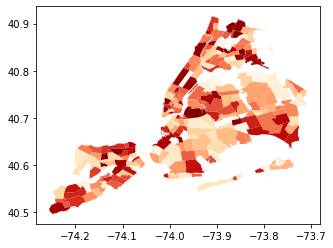

In [16]:
#map graph
map_df.plot(cmap='OrRd')

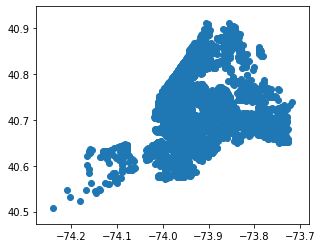

In [17]:
#plot the coordinates (no map)
geo_NYC.plot()

Text(0.5, 1, 'NYC Airbnb sites')

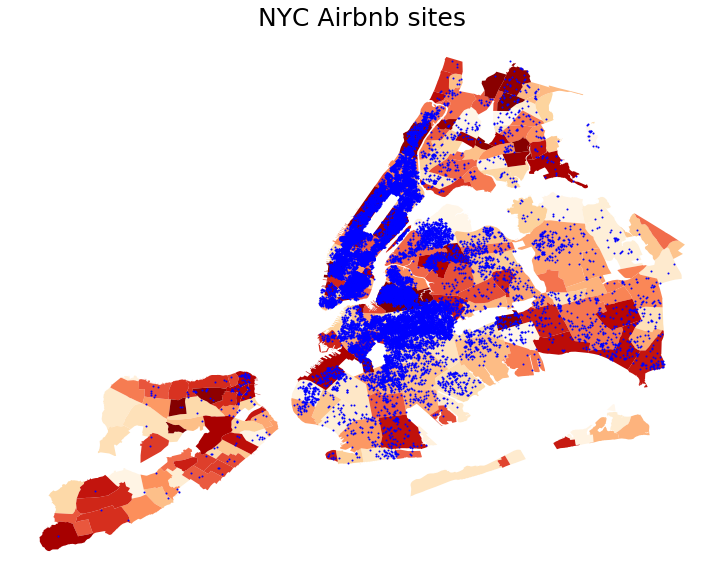

In [18]:
#plot coordinates on top of map graph

#this is to set the size of the borders
fig, ax = plt.subplots(1, figsize=(15,10))

#this is the map
basemap = map_df.plot(ax=ax,cmap='OrRd')

#plot coordinates on top of map graph
geo_NYC.plot(ax=basemap, color='blue', marker=".", markersize=4)

#take off axis numbers
ax.axis('off')

#put title on map
ax.set_title("NYC Airbnb sites", fontsize=25, fontweight=3)

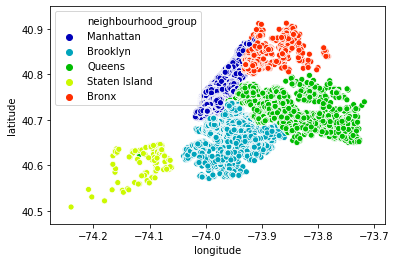

In [19]:
sns.scatterplot(NYC_df.longitude,NYC_df.latitude,hue=NYC_df.neighbourhood_group,palette='nipy_spectral')

# Concluding remark
There seems to be high demand for airbnb services in and around Manhattan, which is the most expensive borough of the city, and we can see this is located on the west side of the city. This figure also goes in line with our conclusion that average prices are high around western part of the city.